In [40]:
import ML_for_WDN
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import wntr
import networkx as nx
from datetime import datetime
import traces
from datetime import timedelta
import pdb
import sklearn
from sklearn import preprocessing
from sklearn import metrics
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import sdt.changepoint as sdt


# Set working directory
abs_path = '/home/ntm/PhD/ML-for-WDN/notebooks/'
os.chdir(abs_path + '..')

In [36]:
df_with_leak = pd.read_excel(
    'data/raw_data/no_leak_clean.xlsx', 
    skiprows=0,
    sheet_name='3011',
    header=0,
)

In [227]:
cols_to_include = ['FM03_head', 'FM04_head'
    #'FM02_head', 'FM03_head', 'FM04_head', 'FM05_head', 'FM06_head', 
    #'FM08_head', 'FM09_head', 'FM11_head', 'FM13_head', 'FM15_head'
    ]

time_series =  df_with_leak[cols_to_include].values

time_series = time_series[2000:5000:20, :]

In [231]:
det = sdt.BayesOffline(
    prior="const", 
    obs_likelihood="full_cov",
    #prior_params={'p': 0.05},
    )
change_points = det.find_changepoints(time_series, prob_threshold=0.4)

#det = sdt.Pelt(cost="l1", min_size=1, jump=10)
#change_points = det.find_changepoints(time_series, 1000, max_exp_cp=4)

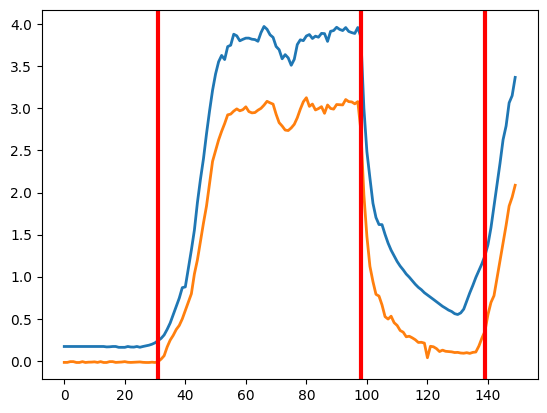

In [232]:
plt.figure()
plt.plot(time_series[:, 0], linewidth=2)
plt.plot(time_series[:, 1], linewidth=2)
for i in range(len(change_points)):
    plt.axvline(x=change_points[i], color='r', linewidth=3)
plt.show()